In [38]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


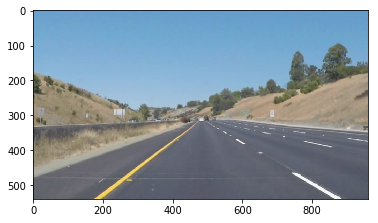

In [39]:
#reading in an image
image = mpimg.imread('D:/CarND-Term1-Starter-Kit-master/CarND-LaneLines-P1-master/test_images/whiteCarLaneSwitch.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape, )
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')


In [40]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    imshape = img.shape
    
    # these variables represent the y-axis coordinates to which 
    # the line will be extrapolated to
    ymin = img.shape[0]
    ymax = img.shape[0]
    
    # right lane line variables
    r_grad = []
    r_y = []
    r_x = []
    
    # left lane line variables
    l_grad = []
    l_y = []
    l_x = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            ymin = min(min(y1, y2), ymin)
            grad, intercept = np.polyfit((x1,x2), (y1,y2), 1)
            
            if (grad > 0):
                l_grad += [grad]
                l_y += [y1, y2]
                l_x += [x1, x2]
            else:
                r_grad += [grad]
                r_y += [y1, y2]
                r_x += [x1, x2]
                
    r_y_mean = np.mean(r_y)
    r_x_mean = np.mean(r_x)
    r_mean_grad = np.mean(r_grad)
    r_intercept = r_y_mean - (r_mean_grad * r_x_mean)
    
    l_y_mean = np.mean(l_y)
    l_x_mean = np.mean(l_x)
    l_mean_grad = np.mean(l_grad)
    l_intercept = l_y_mean - (l_mean_grad * l_x_mean)
    
   
    
    # Make sure we have some points in each lane line category
    if ((len(l_grad) > 0) and (len(r_grad) > 0)):
        upper_r_x = int((ymin - r_intercept) / r_mean_grad)
        lower_r_x = int((ymax - r_intercept) / r_mean_grad)
        upper_l_x = int((ymin - l_intercept) / l_mean_grad)
        lower_l_x = int((ymax - l_intercept) / l_mean_grad)

        cv2.line(img, (upper_r_x, ymin), 
                      (lower_r_x, ymax), color, thickness)
        cv2.line(img, (upper_l_x, ymin), 
                      (lower_l_x, ymax), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1],3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    return cv2.addWeighted(initial_img, α, img, β, γ)


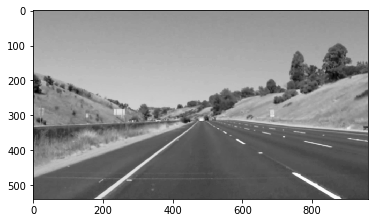

In [41]:
# STEP 1 - Pre-process image using grayscale and gaussian blur
gray_img=grayscale(image);
gray_img=gaussian_blur(gray_img,5)
plt.imshow(gray_img,cmap='Greys_r')

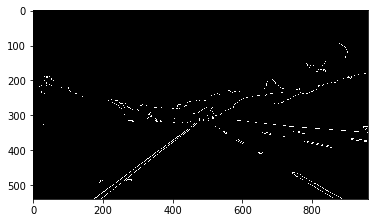

In [42]:
# STEP 2 - Apply canny edge detection to the image 
gray_img_canny=canny(gray_img,100,200)
plt.imshow(gray_img_canny,cmap='Greys_r')

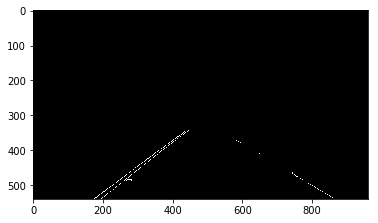

In [43]:
# STEP 3 - Apply masking region to the image 
vertices = np.array([[(150,540),(420,350), (510,330), (875,540)]], dtype=np.int32)
#vertices = np.array([[(190,540),(420,230), (590,290), (875,540)]], dtype=np.int32)
roi_img=region_of_interest(gray_img_canny,vertices)
plt.imshow(roi_img,cmap='Greys_r')

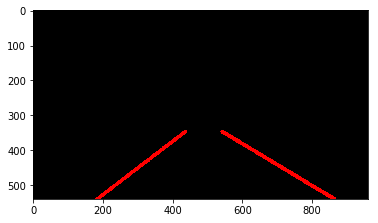

In [44]:
# STEP 4 - Apply Hough transform to the image and extrapolate the lines found in the hough transform to construct the left and right lane lines
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 30   # minimum number of votes (intersections in Hough grid cell)
min_line_length = 8 #minimum number of pixels making up a line
max_line_gap = 8    # maximum gap in pixels between connectable line segments
lines_img=hough_lines(roi_img, rho, theta, threshold, min_line_length, max_line_gap)
plt.imshow(lines_img,cmap='Greys_r')

(540, 960, 3)

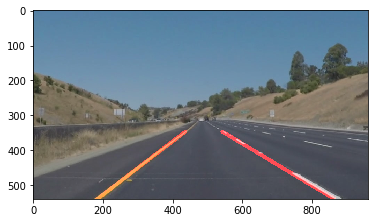

In [45]:
# STEP 5 - Add the extrapolated lines to the input image
final_img=weighted_img(lines_img,image)
plt.imshow(final_img)
final_img.shape

In [46]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import os

In [49]:
# Pipelined to work with video
def process_image(image):
    #grayscale the image
    grayscaled=grayscale(image)
    
    #gaussian blur
    blurred=gaussian_blur(grayscaled,5);
    
    #canny
    minT = 100
    maxT = 200
    cannied = canny(blurred, minT, maxT)
    
    #apply mask
    lowerLeft = [130, 540]
    upperLeft = [410, 350]
    upperRight = [570, 350]
    lowerRight = [915, 540]
    

    points = np.array([[lowerLeft, upperLeft, upperRight, 
                    lowerRight]], dtype=np.int32)
    masked = region_of_interest(cannied, points)
    
    #hough
    rho = 1
    theta = np.pi/180
    threshold = 30
    min_line_len = 20 
    max_line_gap = 20
    houghed = hough_lines(masked, rho, theta, threshold, min_line_len, 
                         max_line_gap)
    
    #Outlining the input image 
    colored_image = weighted_img(houghed, image)
    

    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)

    return colored_image

In [50]:
white_output = 'D:/carnd/CarND-LaneLines-P1-master/test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("D:/carnd/CarND-LaneLines-P1-master/test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video D:/carnd/CarND-LaneLines-P1-master/test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video D:/carnd/CarND-LaneLines-P1-master/test_videos_output/solidWhiteRight.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:09<00:00, 23.61it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: D:/carnd/CarND-LaneLines-P1-master/test_videos_output/solidWhiteRight.mp4 

Wall time: 11.1 s
